**Description**: Tries to answer [my question on stats.stackexchange.com](https://stats.stackexchange.com/q/568492/337906) via simulation. This simulation does not seem to provide a consistent answer. Problems:
1. I thought the variance in predictions decreases as the $l_1$ penalization coefficient (`alpha` in scikit-learn) increases. This simulation does not have this property.
2. The plot is quite sensitive to dataset parameters. I can explore this more. But overall, the simulation doesn't provide consistent evidence for or against the hypothesis that higher variance in predictions causes higher variance in error.

Hopefully I can get around (1) by generating my own data instead of using `sklearn.datasets.make_regression`. I was initially using this function b/c I figured LASSO-generated data would allow ample room for high prediction variance.

**Estimated runtime**: 25 sec. to run the simulation.

**Package requirements**:
```
matplotlib==3.4.3
scikit-learn==0.24.2
tqdm==4.62.3
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, cross_val_predict

from tqdm import tqdm

In [2]:
# globally configure figure sizes to be kinda big
plt.rcParams['figure.figsize'] = (10, 6)

All experiment settings can be set below

In [3]:
# Experiment parameters.
N_SIMULATIONS = 50       # num sets of predictions used to estimate var(preds) and var(error)
N_ESTIMATORS = 21        # num points (var(preds), var(error)) you'll get
N_SPLITS = 5             # k in k-fold CV
RANDOM_STATE_SPLITS = 42 # used to split train and test data in CV

# Dataset parameters. Experiment results are (unforunately) very sensitive to
# these settings.
N_EXAMPLES = 1000        # try to avoid overparameterizing
N_FEATURES = 50          # try to avoid overparameterizing
N_INFORMATIVE = 5        # leave plenty of room for overfitting
NOISE = 30               # as in Y = Xb + N(0, noise^2)
RANDOM_STATE_DATA = 123  # used to generate X, b, and noise

# LASSO model hyperparameters. LASSO b/c it matches the underlying data distr.
REG_STRENGTH_LB = 0.1    # lowest  setting for l1 penalization coefficient
REG_STRENGTH_UB = 10.1   # highest setting for l1 penalization coefficient

Generate data

In [4]:
X, y, coef = make_regression(n_samples=N_EXAMPLES,
                             n_features=N_FEATURES,
                             n_informative=N_INFORMATIVE,
                             noise=NOISE,
                             random_state=RANDOM_STATE_DATA,
                             coef=True)

Initialize estimators

In [5]:
reg_strengths = np.round(np.linspace(start=REG_STRENGTH_LB,
                                     stop=REG_STRENGTH_UB,
                                     num=N_ESTIMATORS), 3)
estimators = [Lasso(alpha=reg_strength) for reg_strength in reg_strengths]
estimator_reprs = '\n'.join(f'Estimator {i}: {estimator}'
                            for i, estimator in enumerate(estimators))
print(f'Initialized {len(estimators)} estimators: \n{estimator_reprs}')

Initialized 21 estimators: 
Estimator 0: Lasso(alpha=0.1)
Estimator 1: Lasso(alpha=0.6)
Estimator 2: Lasso(alpha=1.1)
Estimator 3: Lasso(alpha=1.6)
Estimator 4: Lasso(alpha=2.1)
Estimator 5: Lasso(alpha=2.6)
Estimator 6: Lasso(alpha=3.1)
Estimator 7: Lasso(alpha=3.6)
Estimator 8: Lasso(alpha=4.1)
Estimator 9: Lasso(alpha=4.6)
Estimator 10: Lasso(alpha=5.1)
Estimator 11: Lasso(alpha=5.6)
Estimator 12: Lasso(alpha=6.1)
Estimator 13: Lasso(alpha=6.6)
Estimator 14: Lasso(alpha=7.1)
Estimator 15: Lasso(alpha=7.6)
Estimator 16: Lasso(alpha=8.1)
Estimator 17: Lasso(alpha=8.6)
Estimator 18: Lasso(alpha=9.1)
Estimator 19: Lasso(alpha=9.6)
Estimator 20: Lasso(alpha=10.1)


Run simulation

In [6]:
all_test_preds = np.empty(shape=(len(estimators), N_SIMULATIONS, len(y)))
all_test_preds[:] = np.nan # I want errors if any data is unfilled
for i, estimator in tqdm(enumerate(estimators),
                         desc=f'Fitting and predicting estimators',
                         total=len(estimators)):
    # run repeated k-fold to generate N_SIMULATIONS sets of test preds for this
    # estimator
    for j in tqdm(range(N_SIMULATIONS),
                  desc=f'Estimator {i}: {estimator}',
                  total=N_SIMULATIONS):
        random_state = i*j*RANDOM_STATE_SPLITS # unique
        cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=random_state)
        test_preds = cross_val_predict(estimator, X, y, cv=cv)
        all_test_preds[i,j] = test_preds

Fitting and predicting estimators: 100%|██████████| 21/21 [00:20<00:00,  1.00it/s]


In [7]:
assert np.isnan(all_test_preds).sum() == 0, 'Ruh roh! Some predictions are NaN.'

Compute statistics of interest

In [8]:
# var_preds[i] = estimated total prediction variance for estimators[i]
var_preds = (all_test_preds
             # arr[i,j,k] = pred at test pt k in simulation j of estimators[i]
             .var(axis=1)
             # arr[i,k] = variance of estimators[i] at test pt k (taken across simulations)
             .sum(axis=1))

_squared_errors = (all_test_preds - y[np.newaxis, np.newaxis, :])**2

# var_error[i] = estimated error variance for estimators[i]
var_error = ((_squared_errors)
             # arr[i,j,k] = squared error at test pt k in simulation j of estimators[i]
             .mean(axis=2)
             # arr[i,j] = MSE of estimators[i] in simulation j (taken across test pts)
             .var(axis=1))

# avg_error[i] = estimated error for estimators[i]
avg_error = ((_squared_errors)
             .mean(axis=2)
              # arr[i,j] = MSE of estimators[i] in simulation j (taken across test pts)
             .mean(axis=1))

Plots

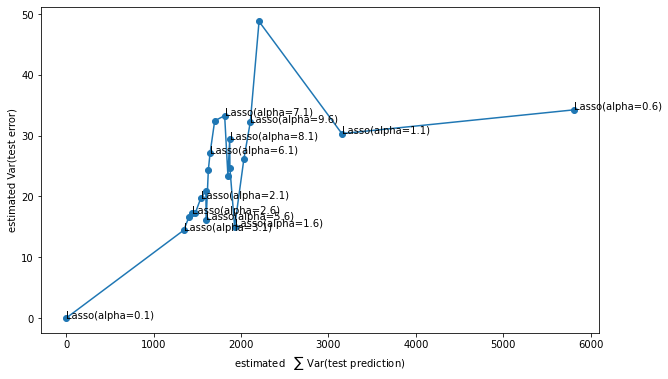

In [9]:
order = np.argsort(var_preds) # sort asc to plot correctly
var_preds_sorted = var_preds[order]
var_error_sorted = var_error[order]
estimators_sorted = np.array(estimators, dtype=object)[order].tolist()

fig, ax = plt.subplots()
ax.plot(var_preds_sorted, var_error_sorted, marker='o')
ax.set_xlabel('estimated   $\sum$ Var(test prediction)')
ax.set_ylabel('estimated Var(test error)')

for i, (pt_x, pt_y, estimator) in enumerate(zip(var_preds_sorted,
                                                var_error_sorted,
                                                estimators_sorted)):
    # annotate endpoints and every other middle-point
    if i == 0 or i == len(estimators_sorted)-1 or i % 2:
        ax.annotate(repr(estimator), (pt_x, pt_y))

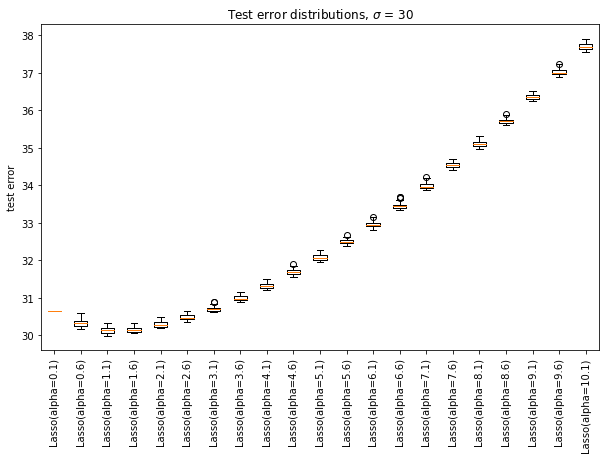

In [10]:
rmses = _squared_errors.mean(axis=2) ** 0.5

fig, ax = plt.subplots()
ax.boxplot(rmses.T)
ax.set_xticklabels([repr(estimator) for estimator in estimators],
                   rotation=90)
ax.set_ylabel('test error')
ax.set_title(f'Test error distributions, $\sigma$ = {NOISE}');